In [4]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter1d 
import numpy as np

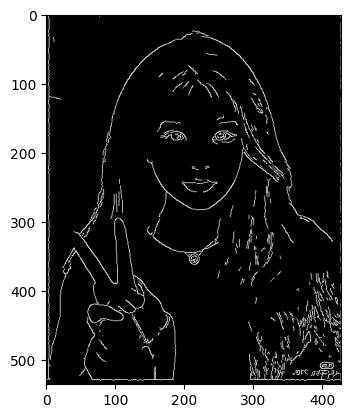

In [5]:
edge_detector = cv2.Canny
img = cv2.imread("faceimages/cutegirl.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
edges = edge_detector(img , 120, 200)
plt.imshow(edges, cmap='gray')

Extracted edges from faceimages/cutegirl.png


Extracted edges from faceimages/cutegirl.png


Extracted edges from faceimages/cutegirl.png


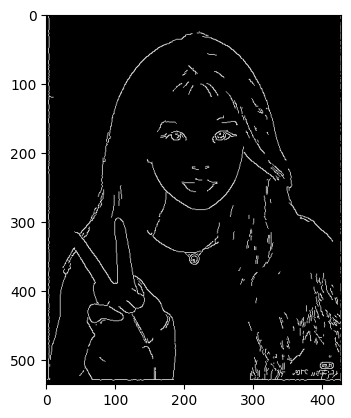

In [6]:

def extract_edges(image_path, min_threshold=100, max_threshold=200):
    """
    Function 1: Load image and extract edges using OpenCV Canny
    
    Returns:
        gray: Grayscale image
        edges: Binary edge map
    """
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(gray, min_threshold, max_threshold)
    
    print(f"Extracted edges from {image_path}")
    return gray, edges

gray, edges = extract_edges("faceimages/cutegirl.png", 130, 220)
edges = np.where(edges > 0, 1, 0)  # Convert to binary 0/1 array
plt.imshow(edges, cmap='gray')



Ordering 2000 edge points...
Ordered 2000 points.
Ordered 2000 points.


Ordering 2000 edge points...
Ordered 2000 points.
Ordered 2000 points.


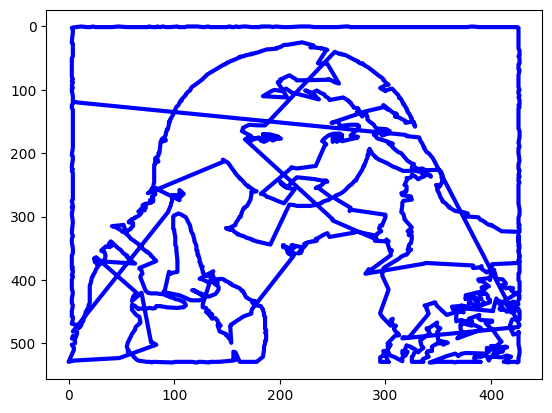

In [7]:


def order_edge_points(edges, n_samples=5000, ord=3):
    """
    Function 2: Extract edge points and order them using nearest neighbor
    
    Returns:
        ordered_points: Nx2 array of ordered (x, y) coordinates
    """
    # Get edge coordinates
    y_coords, x_coords = np.where(edges > 0)
    all_points = np.column_stack((x_coords, y_coords))      #stacking them along column
    
    # Sample if too many points
    if len(all_points) > n_samples:
        indices = np.random.choice(len(all_points), n_samples, replace=False)
        points = all_points[indices]
    else:
        points = all_points
    
    print(f"Ordering {len(points)} edge points...")
    
    # Order points using nearest neighbor
    current = 0
    visited = {current}
    ordered_points = [points[current]]
    
    while len(visited) < len(points):
        current_point = points[current]
        distances = np.linalg.norm(points - current_point,  ord=ord,axis=1)
        distances[list(visited)] = np.inf
        
        next_idx = np.argmin(distances)
        if distances[next_idx] == np.inf:
            break
            
        ordered_points.append(points[next_idx])
        visited.add(next_idx)
        current = next_idx
    
    return np.array(ordered_points)

ordered_points = order_edge_points(edges, n_samples=2000, ord=2)
print(f"Ordered {len(ordered_points)} points.")
plt.plot(ordered_points[:, 0], ordered_points[:, 1], 'b-', linewidth=3)
plt.gca().invert_yaxis() 


4000


4000


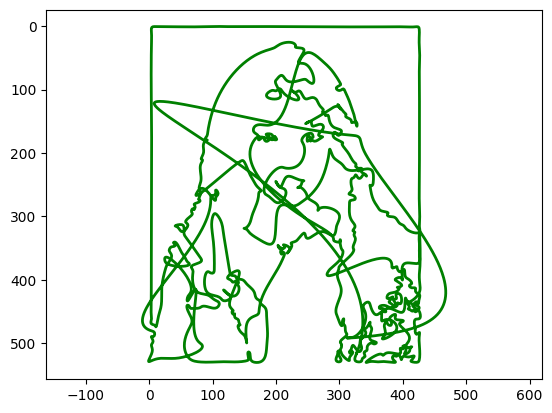

In [8]:
def create_smooth_spline(ordered_points,  smoothing_factor=0.4):
    """
    Function 3: Create smooth spline curve from ordered points
    
    Returns:
        smooth_curve: Mx2 array of smooth curve points
    """
    try:
        #fitting a parametric spline to the ordered points
        tck, u = splprep([ordered_points[:, 0], ordered_points[:, 1]], 
                        s=smoothing_factor * len(ordered_points), 
                        per=True)
        
        #this is sampling it uniformly in time 0 to 1
        u_new = np.linspace(0, 1, len(ordered_points)*2)
        smooth_x, smooth_y = splev(u_new, tck)
        smooth_curve = np.column_stack((smooth_x, smooth_y))

    except:
        print("Spline failed, using Gaussian smoothing")
        smooth_x = gaussian_filter1d(ordered_points[:, 0], sigma=1.0, mode='wrap')
        smooth_y = gaussian_filter1d(ordered_points[:, 1], sigma=1.0, mode='wrap')
        smooth_curve = np.column_stack((smooth_x, smooth_y))

    return smooth_curve


# now if we see we have smooth curve which is the value of the function between 0 and 1

smooth_curve = create_smooth_spline(ordered_points)
print(len(smooth_curve))
plt.plot(smooth_curve[:, 0], smooth_curve[:, 1], 'g-', linewidth=2)
plt.gca().invert_yaxis()  # Flip vertically
plt.axis('equal')
plt.show()


In [9]:
import manim

In [13]:
def fourier_approximate(smooth_curve, n_frequencies=1000):
    """
    Function 4: Approximate smooth curve using Fourier series
    
    Returns:
        frequencies: Integer frequencies for epicycles
        magnitude: Circle radii (amplitudes)
        phases: Starting angles
    """
    # Create complex signal
    z = smooth_curve[:,0] + 1j * smooth_curve[:,1]
    N = len(z)
    
    # Compute FFT and frequencies
    coefficients = np.fft.fft(z , norm='forward')
    frequencies = np.fft.fftfreq(N, 1/N)  # integer frequencies
    
    # Keep n largest components
    indices = np.argsort(-np.abs(coefficients))[:n_frequencies]
    frequencies = frequencies[indices]
    coefficients = coefficients[indices]
    
    # Get amplitudes and phases
    magnitude = np.abs(coefficients)
    phases = np.angle(coefficients)
    
    return frequencies, magnitude, phases

frequencies, magnitude, phases = fourier_approximate(smooth_curve, n_frequencies=200)


In [16]:
from manim import *

class FourierEpicycleScene(Scene):
    def __init__(self, smooth_curve, n_circles=50, rotations=2, duration=10, fade_time=2.0, scale_factor=2.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Compute Fourier coefficients
        frequencies, magnitude, phases = fourier_approximate(smooth_curve, n_frequencies=n_circles)
        
        # Store parameters
        self.frequencies = frequencies
        self.amplitudes = magnitude * scale_factor  # Scale for visibility
        self.phases = phases
        self.N = len(self.frequencies)
        self.rotations = rotations
        self.duration = duration
        self.fade_time = fade_time
    
    def construct(self):
        # Time tracker (0 to 1 for one full rotation)
        t = ValueTracker(0)
        
        # Create circles and arrows
        circles = VGroup(*[
            Circle(radius=self.amplitudes[i], color=BLUE, stroke_width=1.5, stroke_opacity=0.4)
            for i in range(self.N)
        ])
        
        arrows = VGroup(*[
            Arrow(ORIGIN, RIGHT, buff=0, max_tip_length_to_length_ratio=0.15, 
                  stroke_width=2, color=WHITE)
            for i in range(self.N)
        ])
        
        # Traced path for drawing
        path = VMobject(stroke_color=YELLOW, stroke_width=3)
        path.set_points_as_corners([ORIGIN, ORIGIN])
        
        # Helper function to compute cumulative positions at time t
        def get_positions(time_val):
            positions = [np.array([0, 0, 0])]
            for freq, amp, phase in zip(self.frequencies, self.amplitudes, self.phases):
                angle = 2 * PI * freq * time_val + phase
                dx = amp * np.cos(angle)
                dy = amp * np.sin(angle)
                new_pos = positions[-1] + np.array([dx, dy, 0])
                positions.append(new_pos)
            return positions
        
        # Updater for circles and arrows
        def update_epicycles(mob):
            positions = get_positions(t.get_value())
            for i in range(self.N):
                circles[i].move_to(positions[i])
                if i < self.N:
                    arrows[i].put_start_and_end_on(positions[i], positions[i + 1])
        
        epicycles = VGroup(circles, arrows)
        epicycles.add_updater(update_epicycles)
        
        # Updater for path with fading
        path_points = []
        
        def update_path(mob):
            positions = get_positions(t.get_value())
            tip = positions[-1]
            path_points.append(tip.copy())
            
            # Keep only recent points for fading effect
            max_points = int(self.fade_time * 60)  # Approximate frames
            if len(path_points) > max_points:
                path_points.pop(0)
            
            if len(path_points) > 1:
                mob.set_points_as_corners(path_points)
        
        path.add_updater(update_path)
        
        # Add everything to scene
        self.add(epicycles, path)
        
        # Animate
        self.play(
            t.animate.set_value(self.rotations),
            run_time=self.duration * self.rotations,
            rate_func=linear
        )
        
        # Hold final frame
        self.wait(1)
